# Calculate temporal statistical metrics from cloud-masked Sentinel 2 data on small areas (image chips) 

## Imports

In [1]:
import geopandas as gpd
import io
import json
import numpy as np
import pandas as pd
import pprint
import pystac
import pystac_client
from pystac_client import Client
import planetary_computer
import rioxarray
import stackstac
import xarray as xr


## Data

### Chips (geometries)

In [2]:
# copy of a geopandas.GeoDataFrame().to_json()
geojson_chips = '{"type": "FeatureCollection", "features": [{"id": "2", "type": "Feature", "properties": {"chip_id": 2, "easting": 688503.1824475648, "epsg": 32632, "id": "Lerchenauer See", "latitude": 48.19723, "longitude": 11.53678, "maxx": 689460.0, "maxy": 5342280.0, "minx": 687600.0, "miny": 5340420.0, "northing": 5341333.603224352, "tiles": "32UPU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.524234094137505, 48.18928587085897], [11.525055996690533, 48.20600379648934], [11.550065587909714, 48.205451427901956], [11.549235566161816, 48.18873382438354], [11.524234094137505, 48.18928587085897]]]}}, {"id": "3", "type": "Feature", "properties": {"chip_id": 3, "easting": 705439.5861520077, "epsg": 32632, "id": "Kieswerk Ebenhoeh", "latitude": 48.18998, "longitude": 11.76433, "maxx": 706380.0, "maxy": 5342040.0, "minx": 704520.0, "miny": 5340180.0, "northing": 5341111.3411528235, "tiles": "32UPU, 32UQU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.751522831107586, 48.18190724189189], [11.752418453742267, 48.198622128828674], [11.777419839448665, 48.19802037502167], [11.77651610687036, 48.18130583892132], [11.751522831107586, 48.18190724189189]]]}}, {"id": "4", "type": "Feature", "properties": {"chip_id": 4, "easting": 706949.9406789518, "epsg": 32632, "id": "Marzlinger Weiher", "latitude": 48.392441, "longitude": 11.795693, "maxx": 707880.0, "maxy": 5364600.0, "minx": 706020.0, "miny": 5362740.0, "northing": 5363696.487794535, "tiles": "32UPU, 32UQU", "zone_letter": "U", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.782676865182088, 48.38415047868298], [11.783589070509988, 48.40086433526531], [11.808688737925511, 48.400253896920304], [11.807768333467632, 48.38354039650945], [11.782676865182088, 48.38415047868298]]]}}, {"id": "5", "type": "Feature", "properties": {"chip_id": 5, "easting": 704137.0853263629, "epsg": 32632, "id": "Tegernsee", "latitude": 47.7421, "longitude": 11.72314, "maxx": 705060.0, "maxy": 5292180.0, "minx": 703200.0, "miny": 5290320.0, "northing": 5291228.066208213, "tiles": "32UPU, 32UQU, 32TPT, 32TQT", "zone_letter": "T", "zone_number": 32}, "geometry": {"type": "Polygon", "coordinates": [[[11.710230094604286, 47.734234541181756], [11.711098555200053, 47.750951312207526], [11.735885627074119, 47.75036268068942], [11.735009250336178, 47.73364625232421], [11.710230094604286, 47.734234541181756]]]}}, {"id": "1", "type": "Feature", "properties": {"chip_id": 1, "easting": 321827.8428315255, "epsg": 32633, "id": "Raedlinger Weiher", "latitude": 48.67412, "longitude": 12.5797, "maxx": 322740.0, "maxy": 5394960.0, "minx": 320880.0, "miny": 5393100.0, "northing": 5394057.097320923, "tiles": "32UQU, 32UQV, 33UUP, 33UUQ", "zone_letter": "U", "zone_number": 33}, "geometry": {"type": "Polygon", "coordinates": [[[12.567250916755459, 48.66524646552912], [12.5664454366049, 48.68196415944526], [12.591692294447302, 48.68249501125058], [12.59248943795, 48.66577700713926], [12.567250916755459, 48.66524646552912]]]}}]}'
pprint.pprint(json.loads(geojson_chips))

chips = gpd.read_file(io.StringIO(geojson_chips))
chips

{'features': [{'geometry': {'coordinates': [[[11.524234094137505,
                                              48.18928587085897],
                                             [11.525055996690533,
                                              48.20600379648934],
                                             [11.550065587909714,
                                              48.205451427901956],
                                             [11.549235566161816,
                                              48.18873382438354],
                                             [11.524234094137505,
                                              48.18928587085897]]],
                            'type': 'Polygon'},
               'id': '2',
               'properties': {'chip_id': 2,
                              'easting': 688503.1824475648,
                              'epsg': 32632,
                              'id': 'Lerchenauer See',
                              'latitude': 48.19723,
       

,chip_id,easting,epsg,id,latitude,longitude,maxx,maxy,minx,miny,northing,tiles,zone_letter,zone_number,geometry
0,2,688503.182448,32632,Lerchenauer See,48.197230,11.536780,689460.0,5342280.0,687600.0,5340420.0,5.341334e+06,32UPU,U,32,"POLYGON ((11.52423 48.18929, 11.52506 48.20600..."
1,3,705439.586152,32632,Kieswerk Ebenhoeh,48.189980,11.764330,706380.0,5342040.0,704520.0,5340180.0,5.341111e+06,"32UPU, 32UQU",U,32,"POLYGON ((11.75152 48.18191, 11.75242 48.19862..."
2,4,706949.940679,32632,Marzlinger Weiher,48.392441,11.795693,707880.0,5364600.0,706020.0,5362740.0,5.363696e+06,"32UPU, 32UQU",U,32,"POLYGON ((11.78268 48.38415, 11.78359 48.40086..."
3,5,704137.085326,32632,Tegernsee,47.742100,11.723140,705060.0,5292180.0,703200.0,5290320.0,5.291228e+06,"32UPU, 32UQU, 32TPT, 32TQT",T,32,"POLYGON ((11.71023 47.73423, 11.71110 47.75095..."
4,1,321827.842832,32633,Raedlinger Weiher,48.674120,12.579700,322740.0,5394960.0,320880.0,5393100.0,5.394057e+06,"32UQU, 32UQV, 33UUP, 33UUQ",U,33,"POLYGON ((12.56725 48.66525, 12.56645 48.68196..."


### Sentinel 2 data

In [3]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
s2 = catalog.get_collection("sentinel-2-l2a")

pd.DataFrame(s2.extra_fields["summaries"]["eo:bands"])

,name,description,gsd,common_name,center_wavelength,full_width_half_max
0,AOT,aerosol optical thickness,NaN,NaN,NaN,NaN
1,B01,coastal aerosol,60.0,coastal,0.443,0.027
2,B02,visible blue,10.0,blue,0.490,0.098
3,B03,visible green,10.0,green,0.560,0.045
4,B04,visible red,10.0,red,0.665,0.038
5,B05,vegetation classification red edge,20.0,rededge,0.704,0.019
6,B06,vegetation classification red edge,20.0,rededge,0.740,0.018
7,B07,vegetation classification red edge,20.0,rededge,0.783,0.028
8,B08,near infrared,10.0,nir,0.842,0.145
9,B8A,vegetation classification red edge,20.0,rededge,0.865,0.033


## Development for one chip

In [4]:
chip = chips.query('chip_id == 3').iloc[0]
chip

chip_id                                                        3
easting                                            705439.586152
epsg                                                       32632
id                                             Kieswerk Ebenhoeh
latitude                                                48.18998
longitude                                               11.76433
maxx                                                    706380.0
maxy                                                   5342040.0
minx                                                    704520.0
miny                                                   5340180.0
northing                                          5341111.341153
tiles                                               32UPU, 32UQU
zone_letter                                                    U
zone_number                                                   32
geometry       POLYGON ((11.751522831107586 48.18190724189189...
Name: 1, dtype: object

### Get Sentinel 2 scenes

#### Search candidate scenes

In [6]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# later needed for calculating percentiles
datetimes_s1 = ['2018-01-01/2018-03-31',
                '2018-07-01/2018-09-30',
                '2019-01-01/2019-03-31',
                '2019-07-01/2019-09-30']
datetimes_s2 = ['2018-04-01/2018-06-30',
                '2018-10-01/2018-12-31',
                '2019-04-01/2019-06-30',
                '2019-10-01/2019-12-31']
datetimes = '2018-01-01/2019-12-31' # datetimes_s1 + datetimes_s2
datetimes = '2018-04-01/2018-06-30' # short period for development

search = stac.search(
    intersects=dict(type="Point", coordinates=[chip.longitude, chip.latitude]),
    datetime=datetimes,
    collections=["sentinel-2-l2a"],
    limit=500,  # fetch items in batches of 500
    query={"eo:cloud_cover": {"lt": 80},
           # we only work with small chip areas and only use data from one zone
           # this avoids duplicates while we should not miss any data
           "proj:epsg": {'eq': int(chip.epsg)} 
          },
)
candidate_items = list(search.get_items())
print(len(candidate_items))

44


#### Remove duplicates

Duplicates can occure in overlapping areas.

In [7]:
from shapely.geometry import Point, Polygon
## scenes db for overview
ids = []
geometries = []
cloud_cover = []
pt = Point([chip.longitude, chip.latitude])

for item in candidate_items:
    ids.append(item.id)
    # poly = Polygon.from_bounds(*item.bbox)
    assert len(item.geometry['coordinates']) == 1
    poly = Polygon(item.geometry['coordinates'][0])
    geometries.append(poly)
    cloud_cover.append(item.properties['eo:cloud_cover'])

scenes = pd.DataFrame(
    {
        'id': ids,
        'geometry': geometries,
        'cloud_cover': cloud_cover

})

# https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention
candidate_scenes = pd.concat([scenes, scenes.id.str.split('_', expand=True).rename(
    {
        0: 'mission',
        1: 'product_level' ,
        2: 'datatake_sensing_start' ,
        3: 'relative_orbit' ,
        4: 'tile' ,
        5: 'product_discriminator' ,

    }, axis=1)], axis=1)

candidate_scenes['date'] = pd.to_datetime(candidate_scenes['datatake_sensing_start'].str[:8])
candidate_scenes['chip_id'] = chip['chip_id']

candidate_scenes['unique_acquisitions'] = False
keep = candidate_scenes.groupby(['mission', 'date']).first()['id']
candidate_scenes.loc[scenes['id'].isin(keep), 'unique_acquisitions'] = True


scenes = candidate_scenes.query('unique_acquisitions')
items = [it for it in candidate_items if it.id in scenes['id'].values]
assert len(items) == scenes.shape[0]
scenes

,id,geometry,cloud_cover,mission,product_level,datatake_sensing_start,relative_orbit,tile,product_discriminator,date,chip_id,unique_acquisitions
0,S2A_MSIL2A_20180628T101031_R022_T32UPU_2020101...,"POLYGON ((10.5976289 47.75266723, 10.63109219 ...",74.809887,S2A,MSIL2A,20180628T101031,R022,T32UPU,20201012T032109,2018-06-28,3,True
1,S2B_MSIL2A_20180623T101029_R022_T32UPU_2020101...,"POLYGON ((10.59546353 47.75270623, 10.6194372 ...",73.238951,S2B,MSIL2A,20180623T101029,R022,T32UPU,20201012T013625,2018-06-23,3,True
2,S2A_MSIL2A_20180621T102021_R065_T32UQU_2020101...,"POLYGON ((12.59351092 48.69459923, 12.54939825...",26.765513,S2A,MSIL2A,20180621T102021,R065,T32UQU,20201012T003912,2018-06-21,3,True
4,S2A_MSIL2A_20180618T101021_R022_T32UQU_2020101...,"POLYGON ((11.71881526 48.7209277, 13.20828444 ...",70.462350,S2A,MSIL2A,20180618T101021,R022,T32UQU,20201011T233054,2018-06-18,3,True
5,S2B_MSIL2A_20180616T102019_R065_T32UQU_2020101...,"POLYGON ((12.59161471 48.6946563, 12.57069449 ...",9.093094,S2B,MSIL2A,20180616T102019,R065,T32UQU,20201011T225639,2018-06-16,3,True
7,S2B_MSIL2A_20180613T101019_R022_T32UQU_2020102...,"POLYGON ((11.71881526 48.7209277, 13.20828444 ...",76.781879,S2B,MSIL2A,20180613T101019,R022,T32UQU,20201027T001036,2018-06-13,3,True
8,S2A_MSIL2A_20180611T102021_R065_T32UQU_2020102...,"POLYGON ((12.59635188 48.69451371, 12.54918845...",19.475345,S2A,MSIL2A,20180611T102021,R065,T32UQU,20201026T215211,2018-06-11,3,True
10,S2A_MSIL2A_20180608T101021_R022_T32UPU_2020102...,"POLYGON ((11.80715332 47.89550923, 11.7067029 ...",27.107302,S2A,MSIL2A,20180608T101021,R022,T32UPU,20201026T190430,2018-06-08,3,True
11,S2B_MSIL2A_20180606T102019_R065_T32UQU_2020102...,"POLYGON ((12.59606776 48.69452226, 12.53213265...",36.851507,S2B,MSIL2A,20180606T102019,R065,T32UQU,20201026T173753,2018-06-06,3,True
13,S2B_MSIL2A_20180603T101019_R022_T32UQU_2020110...,"POLYGON ((11.71881526 48.7209277, 13.20828444 ...",14.911748,S2B,MSIL2A,20180603T101019,R022,T32UQU,20201103T064033,2018-06-03,3,True


### Single scene / item

#### Select item

In [8]:
selected_item = items[7]
selected_item.assets["rendered_preview"].to_dict()

{'href': 'https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=sentinel-2-l2a&item=S2A_MSIL2A_20180608T101021_R022_T32UPU_20201026T190430&assets=visual&asset_bidx=visual%7C1%2C2%2C3&nodata=0',
 'type': 'image/png',
 'title': 'Rendered preview',
 'rel': 'preview',
 'roles': ['overview']}

#### Show preview

In [9]:
from IPython.display import Image
Image(url=selected_item.assets["rendered_preview"].href, width=500)

#### Create a xarray dataset

Subset to assets and area of interest. 

In [10]:
ds = stackstac.stack(planetary_computer.sign(selected_item), 
                     assets=['B04', 'B08', 'B11', 'B12', 'SCL'],
                     bounds=[chip.minx, chip.miny, chip.maxx, chip.maxy]
                    )
ds

<xarray.DataArray 'stackstac-ed5fb1672ee1a4bf29269ad6876a0d4e' (time: 1,
                                                                band: 5,
                                                                y: 186, x: 186)>
dask.array<fetch_raster_window, shape=(1, 5, 186, 186), dtype=float64, chunksize=(1, 1, 186, 186), chunktype=numpy.ndarray>
Coordinates: (12/44)
  * time                                     (time) datetime64[ns] 2018-06-08...
    id                                       (time) <U54 'S2A_MSIL2A_20180608...
  * band                                     (band) <U3 'B04' 'B08' ... 'SCL'
  * x                                        (x) float64 7.045e+05 ... 7.064e+05
  * y                                        (y) float64 5.342e+06 ... 5.34e+06
    s2:datatake_id                           <U34 'GS2A_20180608T101021_01546...
    ...                                       ...
    proj:bbox                                object {600000.0, 5400000.0, 709...
    gsd                                      (band) float64 10.0 10.0 ... 20.0
    common_name                              (band) object 'red' 'nir' ... None
    center_wavelength                        (band) object 0.665 0.842 ... None
    full_width_half_max                      (band) object 0.038 0.145 ... None
    epsg                                     int64 32632
Attributes:
    spec:        RasterSpec(epsg=32632, bounds=(704520.0, 5340180.0, 706380.0...
    crs:         epsg:32632
    transform:   | 10.00, 0.00, 704520.00|\n| 0.00,-10.00, 5342040.00|\n| 0.0...
    resolution:  10.0

#### Plot data for AOI

##### False color composite

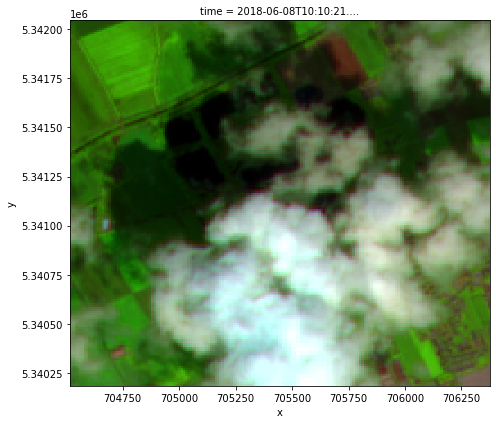

In [11]:
fcc = ds.sel(band=['B11', 'B08', 'B04'])
fcc.plot.imshow(row="time", rgb="band", robust=True, size=6);

##### SCL

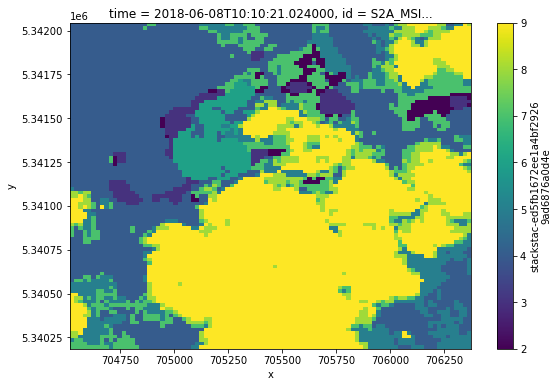

In [12]:
scl = ds.sel(band=['SCL'])
scl.plot(size=6)

#### Mask 'bad' pixels

##### Define valid pixels 

References
* https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
* https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/

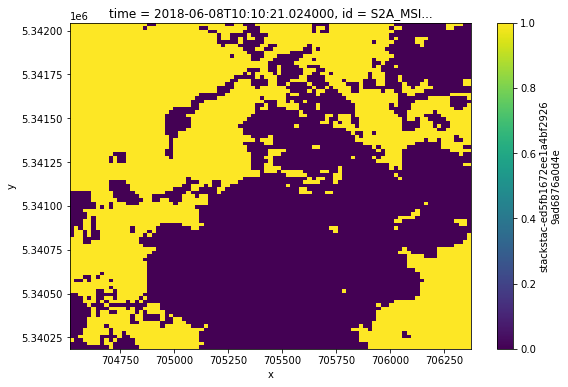

In [13]:
scl_valid_ids = [2, 4, 5, 6]

valid_mask = scl.isin(scl_valid_ids)
valid_mask.plot(size=6)

##### Mask one band

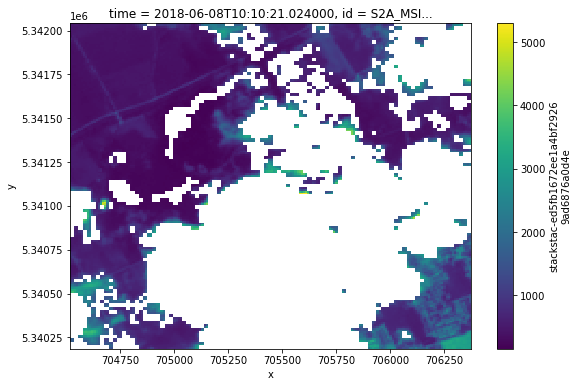

In [14]:
ds.sel(band='B04').where(valid_mask==1, np.nan).plot(size=6)

##### Mask all bands

In [15]:
def mask_band(arr, valid_mask):
    return np.where(valid_mask==1, arr, np.nan)

ds_bands = ds.drop_sel(band='SCL')
ds_bands_masked = xr.apply_ufunc(mask_band, ds_bands, 
                     kwargs={'valid_mask': valid_mask}, dask = 'allowed', vectorize = True)

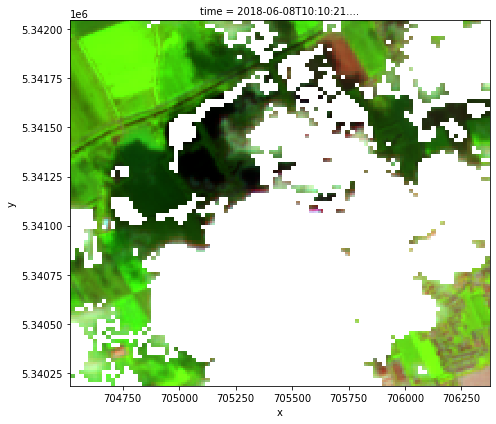

In [16]:
fcc = ds_bands_masked.sel(band=['B11', 'B08', 'B04'])
fcc.plot.imshow(row="time", rgb="band", robust=True, size=6);

### Refactor and apply to all scenes / items

#### Stack all items

In [17]:
ds_all = stackstac.stack(planetary_computer.sign(pystac.ItemCollection(items)), 
                     assets=['B04', 'B08', 'B11', 'B12', 'SCL'],
                     bounds=[chip.minx, chip.miny, chip.maxx, chip.maxy]
                    )
ds_all

,Array,Chunk
Bytes,32.99 MiB,270.28 kiB
Shape,"(25, 5, 186, 186)","(1, 1, 186, 186)"
Count,375 Tasks,125 Chunks
Type,float64,numpy.ndarray


#### Get valid pixel arrays for all scenes

In [18]:
valid_mask_all = ds_all.sel(band='SCL').isin(scl_valid_ids)
valid_mask_all

<xarray.DataArray 'stackstac-b48887df9e39eba9c6301b72619e02b1' (time: 25,
                                                                y: 186, x: 186)>
dask.array<any-aggregate, shape=(25, 186, 186), dtype=bool, chunksize=(1, 186, 186), chunktype=numpy.ndarray>
Coordinates: (12/43)
  * time                                     (time) datetime64[ns] 2018-04-02...
    id                                       (time) <U54 'S2A_MSIL2A_20180402...
    band                                     <U3 'SCL'
  * x                                        (x) float64 7.045e+05 ... 7.064e+05
  * y                                        (y) float64 5.342e+06 ... 5.34e+06
    s2:datatake_id                           (time) <U34 'GS2A_20180402T10202...
    ...                                       ...
    title                                    <U29 'Scene classfication map (S...
    gsd                                      float64 20.0
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32632

#### Mask all scenes

In [19]:
ds_bands_all = ds_all.drop_sel(band='SCL')
ds_bands_all

,Array,Chunk
Bytes,26.39 MiB,270.28 kiB
Shape,"(25, 4, 186, 186)","(1, 1, 186, 186)"
Count,475 Tasks,100 Chunks
Type,float64,numpy.ndarray


In [20]:
def mask_all(x, valid_mask_all):
    return x.where(valid_mask_all==1, np.nan)

ds_bands_masked_all = ds_bands_all.groupby('band').map(mask_all, valid_mask_all = valid_mask_all)
ds_bands_masked_all

,Array,Chunk
Bytes,26.39 MiB,270.28 kiB
Shape,"(25, 4, 186, 186)","(1, 1, 186, 186)"
Count,1101 Tasks,100 Chunks
Type,float64,numpy.ndarray


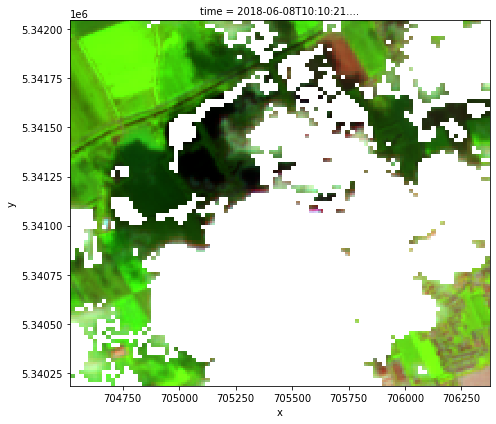

In [21]:
fcc = ds_bands_masked_all.sel(band=['B11', 'B08', 'B04'], time='2018-06-08')
fcc.plot.imshow(row="time", rgb="band", robust=True, size=6);

### Calculate quantiles on masked bands

In [22]:
def quantiles_from_valid_values(x, valid_mask_all):
    x_masked = x.where(valid_mask_all==1, np.nan).chunk(dict(time=-1))
    return x_masked.quantile(q=[0, .05, .10, .25, .50, .75, .90, .95, 1], dim='time')

ds_bands_quantiles = ds_bands_all.groupby('band').map(quantiles_from_valid_values, valid_mask_all = valid_mask_all)
ds_bands_quantiles

<xarray.DataArray 'stackstac-b48887df9e39eba9c6301b72619e02b1' (band: 4,
                                                                y: 186, x: 186,
                                                                quantile: 9)>
dask.array<transpose, shape=(4, 186, 186, 9), dtype=float64, chunksize=(1, 186, 186, 9), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * x                                        (x) float64 7.045e+05 ... 7.064e+05
  * y                                        (y) float64 5.342e+06 ... 5.34e+06
  * quantile                                 (quantile) float64 0.0 0.05 ... 1.0
    s2:degraded_msi_data_percentage          float64 0.0
    s2:processing_baseline                   <U5 '02.12'
    s2:datatake_type                         <U8 'INS-NOBS'
    ...                                       ...
    gsd                                      (band) float64 10.0 10.0 20.0 20.0
    common_name                              (band) object 'red' ... 'swir22'
    center_wavelength                        (band) object 0.665 0.842 1.61 2.19
    full_width_half_max                      (band) object 0.038 0.145 ... 0.242
    epsg                                     int64 32632
  * band                                     (band) <U3 'B04' 'B08' 'B11' 'B12'

In [23]:
fcc = ds_bands_quantiles.sel(band=['B11', 'B08', 'B04'], quantile=[0.1, 0.5, 0.9]).compute()

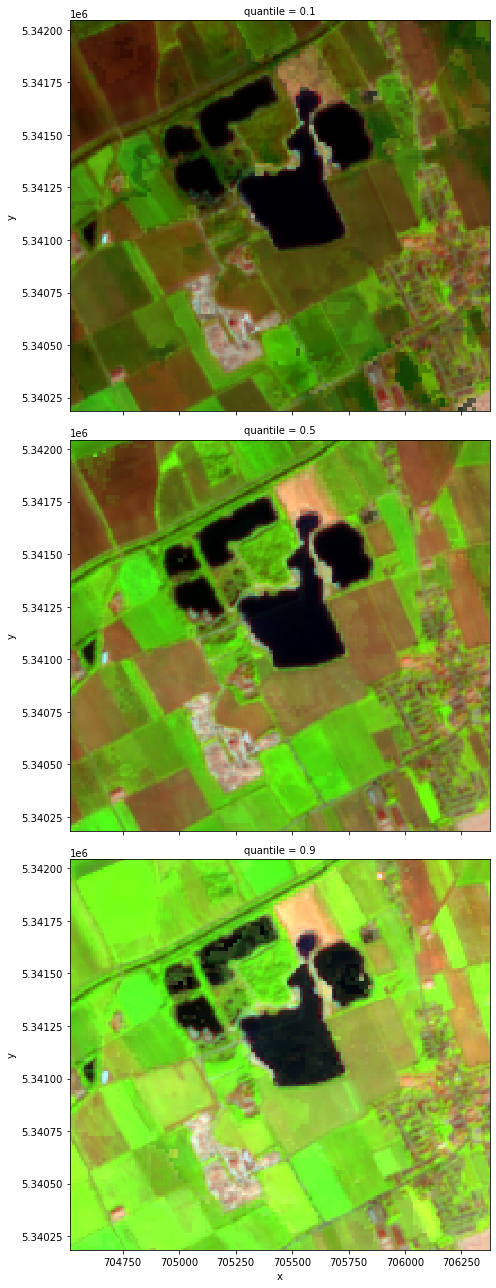

In [24]:
fcc.plot.imshow(row="quantile", rgb="band", robust=True, size=6);

### Save

In [25]:
ds_bands_quantiles_computed = ds_bands_quantiles.compute()

In [26]:
for band in ds_bands_quantiles_computed.coords['band'].values:
    for quantile in ds_bands_quantiles_computed.coords['quantile'].values:
        arr = ds_bands_quantiles_computed.sel(band=band, quantile=quantile)
        filename = f"s2_{datetimes.replace('/', 'TO').replace('-', '')}_band-{band}_quantile-{int(quantile*100):03d}"
        print(filename)
        arr.rio.to_raster(filename, driver='COG', tiled=False)

s2_20180401TO20180630_band-B04_quantile-000
s2_20180401TO20180630_band-B04_quantile-005
s2_20180401TO20180630_band-B04_quantile-010
s2_20180401TO20180630_band-B04_quantile-025
s2_20180401TO20180630_band-B04_quantile-050
s2_20180401TO20180630_band-B04_quantile-075
s2_20180401TO20180630_band-B04_quantile-090
s2_20180401TO20180630_band-B04_quantile-095
s2_20180401TO20180630_band-B04_quantile-100
s2_20180401TO20180630_band-B08_quantile-000
s2_20180401TO20180630_band-B08_quantile-005
s2_20180401TO20180630_band-B08_quantile-010
s2_20180401TO20180630_band-B08_quantile-025
s2_20180401TO20180630_band-B08_quantile-050
s2_20180401TO20180630_band-B08_quantile-075
s2_20180401TO20180630_band-B08_quantile-090
s2_20180401TO20180630_band-B08_quantile-095
s2_20180401TO20180630_band-B08_quantile-100
s2_20180401TO20180630_band-B11_quantile-000
s2_20180401TO20180630_band-B11_quantile-005
s2_20180401TO20180630_band-B11_quantile-010
s2_20180401TO20180630_band-B11_quantile-025
s2_20180401TO20180630_band-B11_q

## Refactor and run for multiple chips

TODO

Given that the chips are small and we want to compute percentiles for multiple time periods it might make sense to 
* load all masked data memory and
* for each period
  * select scenes
  * compute percentiles
  * save data
.